In [33]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


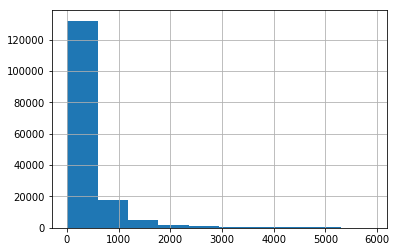

In [6]:
%matplotlib inline
comment_lens = df.comment_text.str.len()
comment_lens.hist()

In [7]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['none'] = 1-df[label_cols].max(axis=1)
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.shape

(159571, 9)

In [43]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [25]:
import re
import string

re_toke = re.compile('([{}""¨«»®´·º½¾¿¡§£₤''])'.format(string.punctuation))

def tokenize(s): 
    return re_toke.sub(r' \1 ', s).split()

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [29]:
n = df.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, 
                      max_df=0.9, strip_accents='unicode', use_idf=1, 
                      smooth_idf=1, sublinear_tf=1)
trn_term_doc = vec.fit_transform(df.comment_text)
test_term_doc = vec.transform(test.comment_text)

In [38]:
def pr(y_i, y):
    """Calculate the probability of y_i in the y vector"""
    p = x[y == y_i].sum(0)
    return (p + 1) / ((y == y_i).sum() + 1)

In [56]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1, y) / pr(0,y)) # finding the log of the count ratio between the respective probabilities of 1 / 0 for the given label
    print(r)
    m = LogisticRegression(C=4, dual=True) 
    x_nb = x.multiply(r) # multiply x feature array by the log count ratio for each class
    return m.fit(x_nb, y), r

In [49]:
x = trn_term_doc
test_x = test_term_doc

In [57]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m, r = get_mdl(df[j]) # df[j] is the column vector with 1/0 labels for each comment type.
    print(r)
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

('fit', 'toxic')
[[ 1.17377807  2.09414789  0.21754661 ...,  0.84486345  0.84486345
   1.79643199]]
[[ 1.17377807  2.09414789  0.21754661 ...,  0.84486345  0.84486345
   1.79643199]]
('fit', 'severe_toxic')
[[ 1.39317753  2.26582632  0.16809293 ...,  3.19559638  3.19559638
   4.14716493]]
[[ 1.39317753  2.26582632  0.16809293 ...,  3.19559638  3.19559638
   4.14716493]]
('fit', 'obscene')
[[ 1.1417381   1.97062102  0.07684393 ...,  1.48457506  1.48457506
   2.43614361]]
[[ 1.1417381   1.97062102  0.07684393 ...,  1.48457506  1.48457506
   2.43614361]]
('fit', 'threat')
[[ 1.28458481  1.97822193  0.74944248 ...,  4.40619733  4.40619733
   5.35776588]]
[[ 1.28458481  1.97822193  0.74944248 ...,  4.40619733  4.40619733
   5.35776588]]
('fit', 'insult')
[[ 1.14232641  1.92000569  0.06228565 ...,  1.55844529  1.55844529
   2.51001383]]
[[ 1.14232641  1.92000569  0.06228565 ...,  1.55844529  1.55844529
   2.51001383]]
('fit', 'identity_hate')
[[ 1.07387449  1.84115371  0.35702124 ...,  3.323

In [47]:
submission = pd.concat([sample, pd.DataFrame(preds, columns = label_cols)], axis=1)
print(test.head())
submission.head()

                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5,0.999988,0.107969,0.999987,0.002361,0.962864,0.094609
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5,0.002870,0.000604,0.001896,0.000100,0.002225,0.000342
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5,0.011797,0.000864,0.005584,0.000102,0.003274,0.000297
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5,0.000955,0.000223,0.001141,0.000171,0.001053,0.000297
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5,0.009971,0.000484,0.002008,0.000131,0.002379,0.000352
